# **Data Science in Python workshop**

### Bryce Macher, Applied Science @ Discovery Channel

_
_
_ 

** teaching materials in these notebooks are solely the property of Bryce Macher, and cannot be used for other workshops or courses other than by the author or by license. Students are open to review these notebooks at any time, but with attribution of credit back to the author.

## Learning Objectives
- Review the relation between correlation and causation
- Understand what a hypothesis test is, and why it is important
- Identify what missing data is and how to handle it
- Test a hypothesis using a sample case study

---

## Data Source

Today, we’ll use advertising data from an example in the book [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).
- This is a well-known, standard introduction to machine learning.
- The book has a more advanced version — [Elements of Statistical Learning](http://web.stanford.edu/~hastie/ElemStatLearn/) — if you are comfortable with linear algebra and statistics at the graduate level.

In [1]:
#import pandas, numpy, and matplotlib packages, 
#include jupyter magic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#this allows us to view visualizations in our notebook
%matplotlib inline

In [2]:
#For google colab, we need to upload files - there are other methods worth exploring on your own. 
from google.colab import files
uploaded = files.upload()

Saving TV-Radio-Newspaper-Sales.txt to TV-Radio-Newspaper-Sales.txt


In [5]:
#Here I'm importing that data table
df = pd.read_csv('TV-Radio-Newspaper-Sales.txt',  index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [6]:
#Show the head
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [7]:
#describe your data using the pandas method for summary statistics
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


## The Normal distribution

---

The Normal distribution is arguably the most commonly used distribution in all of statistics. **Normality** is an assumption that underlies many statistical tests and serves as a convenient model for the distribution of many (but not all!) variables.

The Normal distribution is parameterized by two parameters: 
- the population mean
- the population standard deviation. 

If a variable follows a Normal distribution exactly, its mean, median, and mode will all be equal.

In [8]:
#We can approximate whether we have a normal distribution using .describe() by comparing the mean and the median
df.sales.describe()

count    200.000000
mean      14.022500
std        5.217457
min        1.600000
25%       10.375000
50%       12.900000
75%       17.400000
max       27.000000
Name: sales, dtype: float64

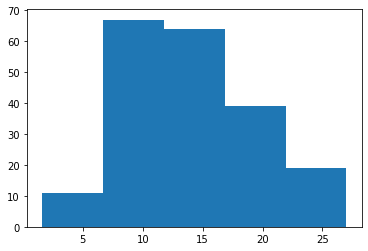

In [18]:
#We can also visualize it!
plt.hist(df['sales'], bins = 5);

Here we are starting to do some statistical computing. We might think this is very abnormally distributed, but it's because we don't have the right bins factor. 

[Read this post if you want to learn all of the different rules for binning](https://medium.com/analytics-vidhya/data-scientists-stop-randomly-binning-histograms-1069d7380c3a)

Typically, though, you should start with scott's rule. Let's look at the pieces of statistical knowledge we need to get there!



# Outliers and Standard Deviation

An outlier in a data series is a signficant deviation from some reasonable value. Let's start with a 'small data' example. In this dataframe, the 'count' is the number of 'values' in the dataset -- this is essentially a visualization of a `value_count()` applied to sales. 

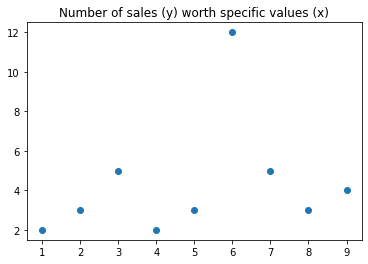

In [20]:
count = [2, 3, 5, 2, 3, 12, 5, 3, 4]
value = [1, 2, 3, 4, 5, 6, 7, 8, 9]

dataframe = pd.DataFrame(list(zip(value, count)), columns = ['value', 'count'])
plt.scatter(x = dataframe['value'], y = dataframe['count'])
plt.title('Number of sales (y) worth specific values (x)');

It's pretty intuitive for us humans to call out which of these does not belong. But computers don't have intuition, so we need to help it out. 

To find the anomaly in a series of numbers, we need to first define what a reasonable value is. A good place to start looking is the mean!

In [21]:
dataframe['count'].mean()

4.333333333333333

... and then, we need to define the deviation. The standard deviation is an easy measure for this. Let's implement this by hand!

 First, we calculate variance - the average squared distance from the mean. 

<p><img height="45px" src="https://www.gstatic.com/education/formulas2/-1/en/sample_variance.svg" align="center" hspace="10px" vspace="0px"></p>

Then, to get to the standard deviation, we simply take the square root of the variance. 

<p><img height="90px" src="https://media.cheggcdn.com/media%2Ffb2%2Ffb229b3b-7787-4b44-b401-93e6a39b5890%2FphpZEGuzV.png" align="center" hspace="10px" vspace="0px"></p>




In [22]:
dataframe.head()

,value,count
0,1,2
1,2,3
2,3,5
3,4,2
4,5,3


In [23]:
#start with an empty list to store our distance calcuations
distance_calc = []

#We start with the top right of the equation: 
## squared value of xi (x at index i) minus the mean of x (x-bar)
for cnt in dataframe['count']:
  distance_calc.append((cnt - dataframe['count'].mean()) ** 2)

#take the sum of that list (Sigma = sum of...), and divide by the length of the results. The is stored as s^2
s2 = round(sum(distance_calc) / (len(distance_calc)-1), 2)

#Take the square root of s2 to get to the standard deviation
standard_deviation = np.sqrt(s2)

standard_deviation

3.082207001484488

Now that we've defined a reasonable value and a deviation, we can define a range of acceptable, expected values. as something that is within 1 standard deviation: mean +- 1*std. Any value outside of that is considered an outlier. 


In [24]:
lower_bound = dataframe['count'].mean() - standard_deviation
upper_bound = dataframe['count'].mean() + standard_deviation

print('lowest expected value in a single deviation is {}'.format(lower_bound))
print('highest expected value in a single deviation is {}'.format(upper_bound))


lowest expected value in a single deviation is 1.251126331848845
highest expected value in a single deviation is 7.4155403348178215


In [34]:
#Create a feature that flags data that is outside of 1 standard deviation in dataframe
dataframe['outlier'] = ((dataframe['count'] < lower_bound) | (dataframe['count'] > upper_bound))
dataframe

,value,count,outlier
0,1,2,False
1,2,3,False
2,3,5,False
3,4,2,False
4,5,3,False
5,6,12,True
6,7,5,False
7,8,3,False
8,9,4,False


Using this approach, you should have found that value 6 (count 12) is outside the range of acceptable values. 

This is fairly imprecise though. What if we want to experiment with what the acceptable number of deviations is? We can instead return a Z-score. 

z-score, or **Standard Score**, is the number of standard deviations from the mean a value is. That means, it's obviously derivative from what we've just done! The Z score for a value is the value-mean, divided by the standard deviation - this returns how many standard deviations outside of the norm the value is.


<p><img height="45px" src="https://www.datavedas.com/wp-content/uploads/2018/01/1.1.2.1.2-Z-Scores-Z-Test-and-Probability-Distribution-3.jpg" align="center" hspace="10px" vspace="0px"></p>




In [35]:
#lets implement this as a function that you'll apply to each cell of the dataframe!
def zScore(cell):
  '''
  Calculates the zscore, returning the zscore per instance. Accepts a single cell at a time. 
  '''
  return (cell - dataframe['count'].mean()) / standard_deviation

In [36]:
#this is the first time you're learning about applying functions - check out this syntax, and let's talk about it's power. 
dataframe['zScore'] = dataframe['count'].apply(zScore)
dataframe

,value,count,outlier,zScore
0,1,2,False,-0.757033
1,2,3,False,-0.432590
2,3,5,False,0.216295
3,4,2,False,-0.757033
4,5,3,False,-0.432590
5,6,12,True,2.487395
6,7,5,False,0.216295
7,8,3,False,-0.432590
8,9,4,False,-0.108148


Let's say we wanted to flag any instances outside of 1.5 standard deviations as an outlier, we could create a boolean feature. 

In [46]:
#create a feature that says whether something is an outlier
dataframe['outlier'] = ((dataframe['zScore'] > 1.5 )| (dataframe['zScore'] < -1.5))

If the business asked you "what percentage of our ideal dataframe is an outlier? Could you answer it now? 

In [47]:
#Check out all of your options in the .value_counts() method
dataframe['outlier'].value_counts(normalize = True)

False    0.888889
True     0.111111
Name: outlier, dtype: float64

This is a great exercise, and having this skill will make you an easy top-hire for any data scientist. New algorithms are constantly being created, and if you can implement and make significant money for the business, you'll be well ahead of teams that have to wait for someone else to implement an algorithm in a standard package that passes security review. 

Let's practice using the sales data!

In [69]:
#get a list of distances
distance_cal = []

#calculate the variance
for val in df.sales:
  distance_cal.append((val - df.sales.mean())**2)

#calculate the standard deviation
s2 = round(sum(distance_cal)/(len(df)-1), 2)

standard_deviation = np.sqrt(s2)

#define the upper and lower bounds for 1 standard deviation
upper_bound = df.sales.mean() + standard_deviation
lower_bound = df.sales.mean() - standard_deviation

#flag any values outside 1 standard deviation, name the feature stdFlag
df['stdFlag'] = (df.sales > upper_bound) | (df.sales < lower_bound)

df.head()

,TV,radio,newspaper,sales,stdFlag,zscore,2_stdFlag
1,230.1,37.8,69.2,22.1,True,3.405351,True
2,44.5,39.3,45.1,10.4,False,1.162803,False
3,17.2,45.9,69.3,9.3,False,0.951965,False
4,151.5,41.3,58.5,18.5,False,2.715336,True
5,180.8,10.8,58.4,12.9,False,1.641980,False


In [75]:
standard_deviation

5.217278984298233

In [76]:
df.stdFlag.value_counts()

False    134
True      66
Name: stdFlag, dtype: int64

In [77]:
#create a standard score function
def zScore(cell):
    return (cell - df['sales'].mean()) / standard_deviation

In [78]:
#apply standard score function to sales
df['zscore'] = df.sales.apply(zScore)

In [79]:
#flag any sales that are outside of TWO standard deviations
df['2_stdFlag'] = (df.zscore > 2) | (df.zscore < -2)

In [80]:
df['2_stdFlag'].value_counts()

False    191
True       9
Name: 2_stdFlag, dtype: int64

While useful as an exercise and skill, sometimes, we would just rather get through this work and onto actually developing insights out of the data. That's why we can use built in functions from pandas to help us with this work!

In [ ]:
#here, let's get the standard deviation. Does it match your answer above? Beware of rounding :)
df.sales.std()

5.217456565710477

Now back to our histogram. The best way to bin a histogram so that you can evaluate whether the distribution is normal is by using scott rule. Scott rule is defined as a way to define the width of the bins in terms of values in the series.  

<p><img height="45px" src="https://docs.scipy.org/doc/numpy-1.14.0/_images/math/0d05809d032cc26458b6631d2c5faadafd99cc48.svg" align="center" hspace="10px" vspace="0px"></p>

 Where 
 - R is`max(value) - min(value)`
 - n is the number of samples
 - σ is the standard deviation

To get to bin count, you then muliply by 1/Range. 

(array([ 2., 14., 29., 53., 35., 25., 19., 14.,  9.]),
 array([ 1.6       ,  4.42222222,  7.24444444, 10.06666667, 12.88888889,
        15.71111111, 18.53333333, 21.35555556, 24.17777778, 27.        ]),
 <a list of 9 Patch objects>)

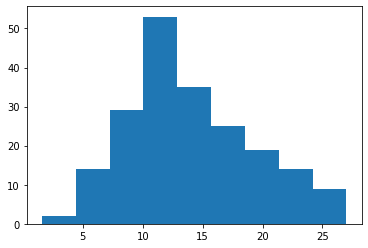

In [ ]:
plt.hist(df.sales, bins = 'scott')

Now you understand the math! Why do you think this presents the most empirical view of whether the distribution is normal? How does this visualization capture what you just learned?

Below is a table comparing some example sample statistics and population parameters:

Metric  | Statistic  | Parameter 
------------- | --------------- | -------------
mean   | $$\bar{x} = \frac{\sum x}{n}$$ | $$ \mu = \frac{\sum x}{N} $$ 
variance | $$ s^2 = \frac{\sum_i (x_i - \bar{x})^2}{n-1} $$ | $$ \sigma^2 = \frac{\sum_i (x_i - \mu)^2}{N}  $$
standard deviation   | $$ s = \sqrt{\frac{\sum_i (x_i - \bar{x})^2}{n-1}} $$ | $$ \sigma = \sqrt{\frac{\sum_i (x_i - \mu)^2}{N} } $$
correlation | $$ r = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{(n-1)s_xs_y }$$ | $$r = \frac{\sum(x_i - \mu_x)(y_i - \mu_y)}{(n)\sigma_x\sigma_y }$$

# Introduction to Hypothesis Testing
---

**Objective**: Test a hypothesis within a sample case study.

You'll remember that we've worked previously on descriptive statistics such as mean and variance. How would we tell if there is a difference between our groups? How would we know if this difference was real or if our finding is simply the result of chance?

Hypothesis Testing is a family of statistical methods used to identify whether a sample of observed data can be used to accept or reject a predefined hypothesis. 

--- 

Imagine you’re checking whether an apple is good or bad, using a random selection of apples from a very large box of apples.
In the below image, we see a clear effect of sample size on the measurements: the effect of one different apple is very large for small samples and the effect of 1 apple becomes smaller and smaller the larger our sample becomes.


<p><img height="545px" src="https://miro.medium.com/max/898/1*Oe4voFKEIDhPrVGO2z24Ag.jpeg" align="center" hspace="10px" vspace="0px"></p>

Understanding the effect of sample size is the first basis towards an understanding of Hypothesis Testing. We could start arguing that 0.5 on 2 apples, would be a 1 apple difference: very likely to happen. But on 100 apples, 0.5 would represent a 50 apple difference: an extremely strong difference!?

Generally speaking, we start with a **null hypothesis** and an **alternative hypothesis**, which is the opposite of the null. Then, you check whether the data support rejecting your null hypothesis or fail to reject the null hypothesis.

> - The __null hypothesis__ is, in general, the boring stuff i.e. it assumes that nothing interesting happens/happened.
- The __alternative hypothesis__ is, where the action is i.e. some observation/ phenomenon is real (i.e. not a fluke) and statistical analysis will give us more insights on that.


For example:

> - **Null hypothesis**: There is no relationship between gender and sales.
- **Alternative hypothesis**: There is a relationship between gender and sales.

Note that "failing to reject" the null hypothesis is not the same as "accepting" it. Your alternative hypothesis may indeed be true, but you don't necessarily have enough data to show that yet.

This distinction is important for helping you avoid overstating your findings. You should only state what your data and analysis can truly represent.

### Example

* The **null hypothesis**, denoted $H_0$, is that there's no difference in two **means** ($\mu_1 = \mu_2$) of a sample
* The **alternative hypothesis**, denoted $H_1$, is that that there's a difference between the means of a sample. 

When doing calculations, we want to be very clear what we're testing. So, we need to define what we mean by 'difference' in our hypothesis test. Some differences can be:
  * low-tailed: $H_1: \mu_1 > \mu_2$
  * high-tailed: $H_1: \mu_1 < \mu_2$
  * two-tailed: $H_1: \mu_1 \neq \mu_2$


---
Let's illustrate this with an example. 
* Hypothesis: There is a statistically significant difference the mean height of men and women. 
* Data: our data comprises a sample of men's heights and a sample of women's heights.
* $H_0: \mu_{men} = \mu_{women}$
* Alternative:
  * low-tailed: $H_1: \mu_{men} > \mu_{women}$
  * high-tailed: $H_1: \mu_{men} < \mu_{women}$
  * two-tailed: $H_1: \mu_{men} \neq \mu_{women}$

Wait... what do you mean statistically significant?

### The p-Value
We are trying to answer a crucial question: “What is the probability that observing a test-statistic, this extreme, for this sample (considering its size and a suitable probabilistic dynamics governing it), is the product of pure chance?"

The simple description of the **p-value** is the probability that, **GIVEN THE NULL HYPOTHESIS IS TRUE**, we would observe the current set of data. 

 The actual definition: 

> For a given statistical model, **GIVEN THE NULL HYPOTHESIS IS TRUE**, the _p-value_ is the probability of observing a statistical summary at least as extreme as the actual observed results.

If your p-value is less than a chosen significance level $\alpha$, then you may choose to reject the null hypothesis and accept there is reasonable evidence to support the alternative hypothesis.

How we check that p-value depends on our research question and the relationship between our values, population, and sample! Let's walk through a few examples. 

In [81]:
#import helper functions
import statsmodels.api as sm

#set a random seed so we are all getting the same answers: 
np.random.seed = 42

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Hypothesis Tests Guide
-
Alternative hypothesis | test
-

- Mean of a variable is different from a reference value | One Sample t-test
- Means of two groups are different | Two Sample t-test
- Means of >2 gropus are different | ANOVA
- % of success in a binary variable is different from a refernece value | Proportions z-test
- % of success in a binary variable is different between two groups | two-propritions z-test

### One Population Proportion
__Research Question__
In previous years, 52% of parents believed that electronics and social media was the cause of their teenager’s lack of sleep. Do more parents today believe that their teenager’s lack of sleep is caused due to electronics and social media?

- __Population__: Parents with a teenager (age 13-18)
- __Parameter of Interest__: p

- __Null Hypothesis__: p = 0.52
- __Alternative Hypthosis__: p > 0.52 (note that this is a one-sided test)

- __Data__: 1018 people were surveyed. 56% of those who were surveyed believe that their teenager’s lack of sleep is caused due to electronics and social media.

In [82]:
n = 1018 #number of surveys
pnull = .52 #previous years' percentage of parents. 
phat = .56 #new group of parents surveyed

Was the increase in responses statistically significant? To test this, we use a one-sided proportions ztest. It is one-sided because we only want to know if the INCREASE is statistically significant - we already know there was an increase. 

__Use of `proportions_ztest()` from `statsmodels`__:
Note the argument `alternative="larger"` indicating a one-sided test. The function returns two values - the z-statistic and the corresponding p-value.

In [83]:
h_test = sm.stats.proportions_ztest(phat * n, n, pnull, alternative='larger')
print('z-stat: {}'.format(h_test[0]))
print('p-value: {}'.format(h_test[1]))

z-stat: 2.571067795759113
p-value: 0.005069273865860533


**Conclusion of the hypothesis test**:  Since the calculated p-value of the z-test is <.05, there is a low probability that, assuming the null hypothesis, the results of this survey increase are randomly by chance. 

We can thus reject the Null hypothesis that the percentage of parents is the same as previous years' estimate, i.e. 52%.

Although, we do not accept the alternate hypothesis, this informally means that there is a good chance of this proportion being more than 52%.

---

### Difference in Population Proportions
__Research Question__
Is there a significant difference between the population proportions of parents of African American children and parents of Hispanic children who report that their child has had some swimming lessons?

- __Populations__: All parents of African American children age 6-18 and all parents of Hispanic children age 6-18
- __Parameter of Interest__: p1 - p2, where p1 = African American and p2 = hispanic

- __Null Hypothesis__: p1 - p2 = 0
- __Alternative Hypthesis__: p1 - p2 $\neq$ = 0

- __Data__: 247 Parents of African American Children. 36.8% of parents report that their child has had some swimming lessons. 308 Parents of Hispanic Children. 38.9% of parents report that their child has had some swimming lessons.

In [84]:
n1 = 247 #parents of African American Children
p1 = .36 #percent reporting that their children had swimming lessons

n2 = 308 #parents of hispanic children
p2 = .38 #percentage reporting swimming lessons

#simulate survey data that adheres to the report above
## We do not care about individuals or orders, so this will allow us to cmopare samples
population1 = np.random.binomial(1, p1, n1) 
population2 = np.random.binomial(1, p2, n2) 

In [85]:
population1

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

__Use of `ttest_ind()` from `statsmodels`__

Difference in population proportion needs t-test. Also, the population follows a binomial distribution here. We can just pass on the two population quantities with the appropriate binomial distribution parameters to the t-test function.

The function returns three values: (a) test statisic, (b) p-value of the t-test, and (c) degrees of freedom used in the t-test.

In [87]:
sm.stats.ttest_ind(population1, population2)[1]

0.9335811382486486

**Conclusion of the hypothesis test**: Since the p-value is quite high, we cannot reject the Null hypothesis in this case i.e. the difference in the population proportions are not statistically significant.

---

### One Population Mean
__Research Question__
Let's say a cartwheeling competition was organized for some adults. 
The data looks like following,
(80.57, 98.96, 85.28, 83.83, 69.94, 89.59, 91.09, 66.25, 91.21, 82.7 , 73.54, 81.99, 54.01, 82.89, 75.88, 98.32, 107.2 , 85.53, 79.08, 84.3 , 89.32, 86.35, 78.98, 92.26, 87.01)

Is there a statistically significant chance that the average cartwheel distance (in inches) for adults more than 80 inches?

- __Population__: All adults
- __Parameter of Interest__: $\mu$, population mean cartwheel distance.
- __Null Hypothesis__: $\mu$ = 80 
- __Alternative Hypothesis__: $\mu$ > 80
- __Data__: 
    - 25 adult participants. 
    - $\mu = 83.84$ 
    - $\sigma = 10.72$

In [90]:
cwdata = np.array([80.57, 98.96, 85.28, 83.83, 69.94, 89.59, 91.09, 66.25, 91.21, 82.7 , 73.54, 81.99, 54.01, 
                 82.89, 75.88, 98.32, 107.2 , 85.53, 79.08, 84.3 , 89.32, 86.35, 78.98, 92.26, 87.01])

In [91]:
n = len(cwdata) #number of samples
mean = cwdata.mean() #mean
sd = cwdata.std() #standard deviation
(n, mean, sd)

(25, 83.84320000000001, 10.716018932420752)

In [92]:
sm.stats.ztest(cwdata, value = 80, alternative = "larger")

(1.756973189172546, 0.039461189601168366)

__Conclusion of the Hypothesis Test__
Since the p-value (0.0394) is lower than the standard confidence level 0.05, we can reject the Null hypothesis that the mean cartwheel distance for adults (a population quantity) is equal to 80 inches. There is strong evidence in support for the alternatine hypothesis that the mean cartwheel distance is, in fact, higher than 80 inches. Note, we used alternative="larger" in the z-test.
We can also plot the histogram of the data to check if it approximately follows a Normal distribution.

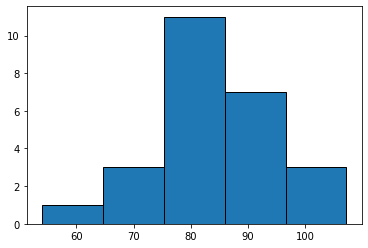

In [93]:
#let's verify with a visualization!
plt.hist(cwdata,bins='scott',edgecolor='k')
plt.show()

What can you draw from this? 

---

###Difference in Population Means

Research Question Considering adults in the NHANES data, do males have a significantly higher mean Body Mass Index than females? Population: Adults in the NHANES data. Parameter of Interest:  𝜇1−𝜇2 , Body Mass Index.

Null Hypothesis:  𝜇1=𝜇2 
Alternative Hypothesis:  𝜇1≠𝜇2 
Data:
2976 Females
2759 Male Adults

In [94]:
#import the BMI_NHANES.csv data
from google.colab import files
uploaded = files.upload()

Saving BMI_NHANES.csv to BMI_NHANES.csv


In [95]:
#read into pandas
health = pd.read_csv('BMI_NHANES.csv')
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5735 non-null   int64  
 1   ALQ101    5208 non-null   float64
 2   ALQ110    1731 non-null   float64
 3   ALQ130    3379 non-null   float64
 4   SMQ020    5735 non-null   int64  
 5   RIAGENDR  5735 non-null   int64  
 6   RIDAGEYR  5735 non-null   int64  
 7   RIDRETH1  5735 non-null   int64  
 8   DMDCITZN  5734 non-null   float64
 9   DMDEDUC2  5474 non-null   float64
 10  DMDMARTL  5474 non-null   float64
 11  DMDHHSIZ  5735 non-null   int64  
 12  WTINT2YR  5735 non-null   float64
 13  SDMVPSU   5735 non-null   int64  
 14  SDMVSTRA  5735 non-null   int64  
 15  INDFMPIR  5134 non-null   float64
 16  BPXSY1    5401 non-null   float64
 17  BPXDI1    5401 non-null   float64
 18  BPXSY2    5535 non-null   float64
 19  BPXDI2    5535 non-null   float64
 20  BMXWT     5666 non-null   floa

In [99]:
#filter the male and female dataframes into two separate objects. Females RIAGENDR = 2, males = 1
females = health[health.RIAGENDR == 2].copy()
males = health[health.RIAGENDR == 1].copy()

In [100]:
#get the number of females
n1 = males.shape[0]
#calculate the mean of BMXBMI
mu1 = males.BMXBMI.mean()
#calculate the standard deviation of BMXBMI
sd1 = males.BMXBMI.std()

In [101]:
#repeat the above cell calculations for men
n2 = females.shape[0]
mu2 = females.BMXBMI.mean()
sd2 = females.BMXBMI.std()

In [104]:
#calcualte if the averages are the same using a comparitor
print(mu1 == mu2)
#show the difference in the means
print(mu1 - mu2)

False
-1.1618735403270115


In [117]:
#now we can see if these are statistically representative 
pval = sm.stats.ztest(females["BMXBMI"].dropna(), males["BMXBMI"].dropna(),alternative='smaller')[1]
round(pval, 2)

1.0

**Conclusion of the hypothesis test**: Since the p-value (6.59e-10) is extremely small, we can reject the Null hypothesis that the mean BMI of males is same as that of females. Note, we used alternative="two-sided" in the z-test because here we are checking for inequality.

Create a histogram of the data to check if it approximately follows a Normal distribution.

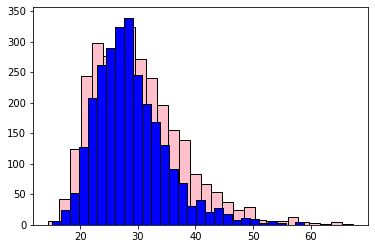

In [116]:
#matplotlib code
plt.hist(females["BMXBMI"].dropna(),edgecolor='k',color='pink',bins='scott')
plt.hist(males["BMXBMI"].dropna(),edgecolor='k',color='blue',bins='scott')
plt.show()

---
#Review

In this notebook, we covered 
- basic descriptive statistics and statistical measures of dispersion for understanding outliers
- how to implement formulae in python, allowing us to transform math into insights
- examined hypothesis tests to understand if we can be confident that our data in a sample reflects an empirical, statistically significant reality